In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os

plt.style.use('./assets/stylesheets/soc_base.mplstyle')

In [101]:
df = pd.read_csv('data/expected_points.csv',index_col=0).reset_index(drop=True)

In [102]:
def compute_points(x,y):
    if x > y:
        return 3
    if x==y:
        return 1
    else:
        return 0

In [103]:
df['xpoints1'] = df['prob1']*3 + df['probtie']
df['xpoints2'] = df['prob2']*3 + df['probtie']
df['points1'] = [compute_points(x,y) for x,y in zip(df['score1'],df['score2'])]
df['points2'] = [compute_points(y,x) for x,y in zip(df['score1'],df['score2'])]

In [104]:
df_team1 = df[['team1','league_id','xpoints1','points1']]
df_team2 = df[['team2','league_id','xpoints2','points2']]
df_team1.columns = ['team','league_id','xpoints','points']
df_team2.columns = ['team','league_id','xpoints','points']
df_g = (
    pd.concat([df_team1,df_team2])
        .groupby(['team']).sum()
        .reset_index()
        .assign(difference=lambda x:x.points - x.xpoints)
)

In [105]:
df_top10 = df_g.sort_values(by='difference').head(20).reset_index(drop=True)

In [106]:
team_map = {
    'team': [
        'Strasbourg',
        'Bayer Leverkusen',
        'Leicester City',
        'VfL Bochum',
        'Sampdoria',
        'AC Ajaccio',
        'Liverpool',
        'Bayern Munich',
        'Internazionale',
        'Elche',
        'Wolverhampton',
        'VfB Stuttgart'
        
    ],
    'fotmob_id':[
        9848,
        8178,
        8197,
        9911,
        9882,
        8576,
        8650,
        9823,
        8636,
        10268,
        8602,
        10269
    ],
    'country':[
        'fra',
        'deu',
        'eng',
        'deu',
        'ita',
        'fra',
        'eng',
        'deu',
        'ita',
        'esp',        
        'eng',
        'deu'
    ]
}

team_map = pd.DataFrame(team_map)

In [107]:
df_top10 = pd.merge(df_top10,team_map)

In [108]:
def get_cumpoints_df(team,data=df):
    df = data.copy()
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    is_in_home = df[(df['team1']==team)][['team1','points1','xpoints1','date']].reset_index(drop=True)
    is_in_away = df[(df['team2']==team)][['team2','points2','xpoints2','date']].reset_index(drop=True)
    is_in_home.columns = ['team','points','xpoints','date']
    is_in_away.columns = ['team','points','xpoints','date']
    df = pd.concat([is_in_home,is_in_away]).sort_values(by="date",ascending=True).reset_index(drop=True)
    df['cum_points'] = df['points'].cumsum()
    df['cum_xpoints'] = df['xpoints'].cumsum()
    return df

In [109]:
def plot_point_difference(ax,team, label_y = False,data = df):
    ax.grid(ls='--',color='lightgrey')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linestyle('dashed')
    ax.tick_params(color='lightgrey',labelsize=8, labelcolor='grey')
    test_df = get_cumpoints_df(team, data)
    
    ax.plot(test_df.index + 1, test_df['cum_points'],marker='o',mfc='white',ms=5,color='#287271')
    ax.plot(test_df.index + 1, test_df['cum_xpoints'],marker='o',mfc='white',ms=5,color='#D81159')
    ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_ylim(-1,22)
    ax.set_xlim(0.25)
    ax.set_xticklabels([])
    mid_point = test_df['cum_points'].iloc[-1] + (test_df['cum_xpoints'].iloc[-1] - test_df['cum_points'].iloc[-1])/2
    difference = test_df['cum_points'].iloc[-1] - test_df['cum_xpoints'].iloc[-1]
    text_ = ax.annotate(
        xy = (ax.get_xlim()[1],mid_point),
        text = f'{difference:.1f}',
        xytext = (-5,0),
        ha='center', va='center',
        color='#D81159',weight='bold',
        size=7,textcoords='offset points'
    )
    text_.set_path_effects([path_effects.Stroke(linewidth=1.5,foreground='white'),path_effects.Normal()])
    
    if label_y:
        ax.set_ylabel('Points',color='grey',size=8)
    else:
        ax.set_yticklabels([])

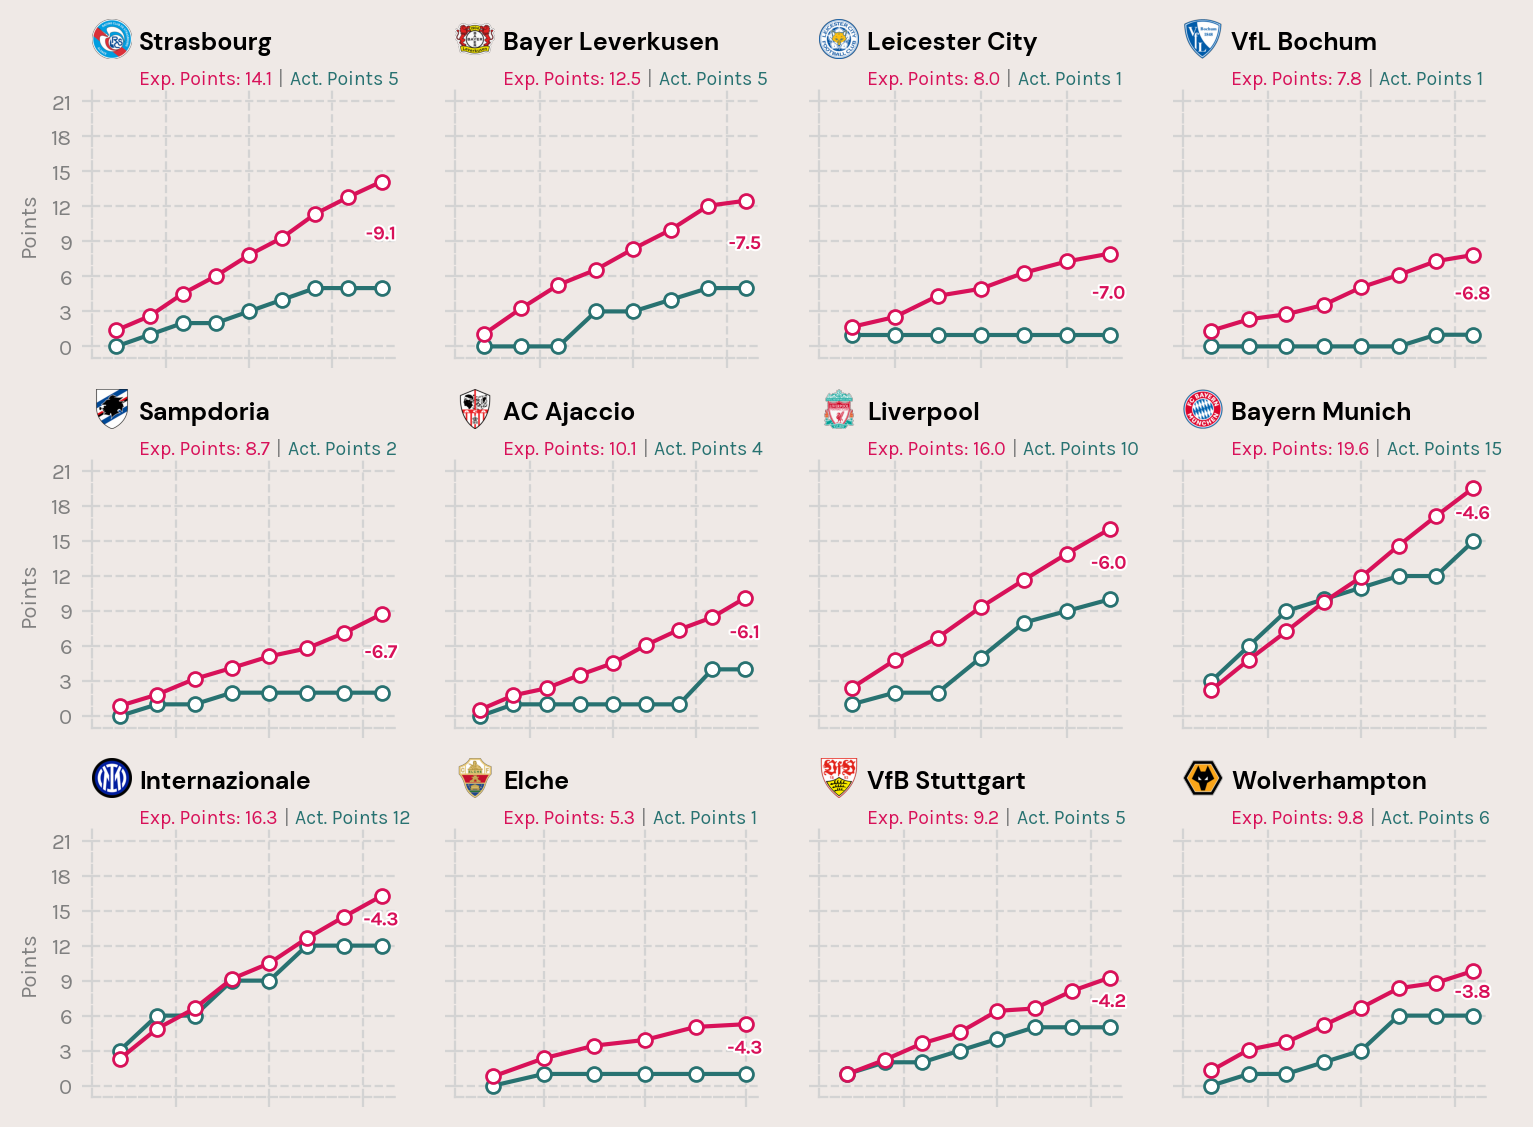

In [110]:
fig = plt.figure(figsize=(9,7),dpi=200)
nrows = 6
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols,nrows=nrows,figure=fig,
    height_ratios=[(1/nrows)*2.6 if x%2!=0 else (1/nrows)/2.6 for x in range(nrows)], hspace=.2
)

plot_counter=0
logo_counter=0
for row in range(nrows):
    for col in range(ncols):
        if row%2 != 0:
            ax = plt.subplot(
                gspec[row,col],
                facecolor="#EFE9E6"
            )
            team = df_top10['team'].iloc[plot_counter]
            if col == 0:
                label_y = True
            else:
                label_y = False
            plot_point_difference(ax,team,label_y)
            plot_counter += 1
        else:
            teamId = df_top10['fotmob_id'].iloc[logo_counter]
            teamName = df_top10['team'].iloc[logo_counter]
            xpoints = df_top10['xpoints'].iloc[logo_counter]
            apoints = df_top10['points'].iloc[logo_counter]
            fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = 'NW', facecolor='#EFE9E6'
            )
            club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{teamId:.0f}.png'))
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')
            
            ax_text(
                x=1.2,
                y=.7,
                s=f'<{teamName}>\n<Exp. Points: {xpoints:.1f}> <|> <Act. Points {apoints:.0f}>',
                ax = logo_ax,
                highlight_textprops=[{'weight':'bold', 'font':'DM Sans'},
                                     {'size':'7', 'color': '#D81159'}, 
                                     {'size':'7', 'color': 'grey'}, 
                                     {'size':'7', 'color': '#287271'}],
                font='Karla',
                ha='left',
                size=9,
                annotationbbox_kw={'xycoords':'axes fraction'}
            )
            logo_counter += 1